## Optimization Project 2

## Problems 1-3

### Imports and Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
%matplotlib inline

In [2]:
# For Number of seats
M_c = 100  # coach seats
M_f = 20   # first-class seats
fc_max = M_f

# For Show-up probabilities
p_show_c = 0.95  # coach
p_show_f = 0.97  # first-class

# Ticket prices
price_coach = [300, 350]  
price_first = [425, 500]  

# Daily probabilities of selling a ticket (if not sold out)
# If first-class is NOT sold out:
p_coach_day = [0.65, 0.30]  
p_first_day = [0.08, 0.04]  

# If first-class IS sold out, coach probability increases by 3 percentage points
p_coach_day_fullF = [0.68, 0.33]

# Overbooking costs
cost_bump_up  = 50   # cost to bump coach passenger to first-class
cost_bump_off = 425  # cost to bump coach passenger off the plane

# Time parameters
T = 365  # number of days to sell
annual_discount_rate = 0.17
delta = 1.0 / (1.0 + annual_discount_rate / 365.0)  # daily discount factor

**Function to Compute Overbooking Cost**

The function computes the expected cost of overbooking given that:

- 'sold_coach' coach tickets have been sold
  
- 'sold_first' first-class tickets have been sold

Each coach passenger shows with prob p_show_c,  each first-class passenger with prob p_show_f. If more coach passengers arrive than coach seats, some can be bumped tofirst-class (if there's capacity), each incurring cost_bump_up. Any coach passenger who can't be seated at all costs cost_bump_off.


In [3]:
def coach_prob(price_coach, fc_sold_out, coach_full):
    if coach_full:
        return 0.0
    if price_coach == 300:
        base_p = 0.65
    else:
        base_p = 0.30
    if fc_sold_out:
        base_p += 0.03
    return min(base_p, 1.0)

def fc_prob(price_fc, coach_full, fc_sold):
    if coach_full:
        return 0.0
    if fc_sold >= fc_max:
        return 0.0
    if price_fc == 425:
        return 0.08
    else:
        return 0.04


In [4]:
def overbooking_cost(sold_coach, sold_first,
                     M_c=M_c, M_f=M_f,
                     p_show_c=p_show_c, p_show_f=p_show_f,
                     cost_bump_up=cost_bump_up, cost_bump_off=cost_bump_off,
                     fc_max=M_f):
    expected_cost = 0.0
    for k in range(sold_coach + 1):
        # Probability exactly k coach passengers show up
        prob_k = binom.pmf(k, sold_coach, p_show_c)
        for m in range(sold_first + 1):
            # Probability exactly m first-class passengers show up
            prob_m = binom.pmf(m, sold_first, p_show_f)
            # Overflow in coach: passengers above the physical capacity
            overflow_coach = max(k - M_c, 0)
            # Remaining seats in first-class using fc_max
            leftover_first = max(fc_max - m, 0)
            # We can bump up to leftover_first passengers from the coach overflDow
            bumped_up = min(overflow_coach, leftover_first)
            bumped_off = overflow_coach - bumped_up
            scenario_cost = cost_bump_up * bumped_up + cost_bump_off * bumped_off
            expected_cost += scenario_cost * prob_k * prob_m
    return expected_cost

**Dynamic Programming Array Intialization**

**Question 1: Where we allow overbooking only by 5 seats**

In [5]:
def solve_airline_overbooking(overbook=5):
    # State space sizes
    max_coach = M_c + overbook
    max_first = M_f  # first-class does not allow overbooking

    # Create DP arrays
    V = np.zeros((max_coach+1, max_first+1, T+1))
    policy_coach = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    policy_first = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)

    # Terminal condition at t = T: only incur the (negative) overbooking cost
    for s_c in range(max_coach+1):
        for s_f in range(max_first+1):
            cost = overbooking_cost(s_c, s_f)
            V[s_c, s_f, T] = -cost

    # Backward recursion for t = T-1 down to 0
    for t in reversed(range(T)):
        for s_c in range(max_coach+1):
            for s_f in range(max_first+1):
                best_value = -1e15
                best_coach_choice = 0
                best_first_choice = 0

                # For each possible price choice:
                # Coach: low (300) or high (350)
                # First-class: low (425) or high (500)
                for coach_choice in [0, 1]:
                    # Determine if first-class is sold out and if coach is at its limit
                    fc_sold_out = (s_f >= fc_max)
                    coach_full = (s_c >= max_coach)
                    # Get coach sale probability using helper function
                    p_c = coach_prob(price_coach[coach_choice], fc_sold_out, coach_full)

                    for first_choice in [0, 1]:
                        # Get first-class sale probability using helper function
                        p_f = fc_prob(price_first[first_choice], coach_full, s_f)

                        # Clamp next state indices so that we never exceed our state space
                        next_s_c = min(s_c + 1, max_coach)
                        next_s_f = min(s_f + 1, max_first)

                        # Immediate revenue if a sale occurs:
                        revenue_coach = price_coach[coach_choice]
                        revenue_first = price_first[first_choice]

                        # Compute the expected value over the four outcomes:
                        # (0,0): No sale in either class
                        val_00 = (1 - p_c) * (1 - p_f) * (0.0 + delta * V[s_c, s_f, t+1])
                        # (1,0): Coach sale only
                        val_10 = p_c * (1 - p_f) * (revenue_coach + delta * V[next_s_c, s_f, t+1])
                        # (0,1): First-class sale only
                        val_01 = (1 - p_c) * p_f * (revenue_first + delta * V[s_c, next_s_f, t+1])
                        # (1,1): Both sales occur
                        val_11 = p_c * p_f * ((revenue_coach + revenue_first) + delta * V[next_s_c, next_s_f, t+1])

                        total_val = val_00 + val_10 + val_01 + val_11

                        if total_val > best_value:
                            best_value = total_val
                            best_coach_choice = coach_choice
                            best_first_choice = first_choice

                V[s_c, s_f, t] = best_value
                policy_coach[s_c, s_f, t] = best_coach_choice
                policy_first[s_c, s_f, t] = best_first_choice

    # Return the full DP arrays and the optimal profit from the initial state.
    return V, policy_coach, policy_first, V[0, 0, 0]

In [6]:
V_5, pol_c_5, pol_f_5, profit_5 = solve_airline_overbooking(overbook=5)
print("Expected discounted profit with overbooking = 5:", profit_5)

Expected discounted profit with overbooking = 5: 41792.4043978528


**Question 2: where we vary overbooking from 5 to 15**

In [7]:
best_overbook = None
best_profit = -1e15

for ob in range(5, 16):  # 5..15 inclusive
    _, _, _, this_profit = solve_airline_overbooking(overbook=ob)
    print(f"Overbooking={ob}, Expected Profit={this_profit:.2f}")
    if this_profit > best_profit:
        best_profit = this_profit
        best_overbook = ob

print("Best overbooking policy is:", best_overbook)
print("With expected discounted profit =", best_profit)

Overbooking=5, Expected Profit=41792.40
Overbooking=6, Expected Profit=41930.97
Overbooking=7, Expected Profit=42017.84
Overbooking=8, Expected Profit=42065.71
Overbooking=9, Expected Profit=42087.94
Overbooking=10, Expected Profit=42094.43
Overbooking=11, Expected Profit=42091.94
Overbooking=12, Expected Profit=42084.78
Overbooking=13, Expected Profit=42075.60
Overbooking=14, Expected Profit=42065.93
Overbooking=15, Expected Profit=42056.61
Best overbooking policy is: 10
With expected discounted profit = 42094.4307402182


**Question 3: Comparision with no sale policy**

In [8]:
def solve_airline_overbooking_with_nosale(overbook=5):
    max_coach = M_c + overbook
    max_first = M_f

    # Create DP arrays
    V = np.zeros((max_coach+1, max_first+1, T+1))
    policy_coach = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    policy_first = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)

    # 1) Boundary condition at t = T: only overbooking costs (negative)
    for s_c in range(max_coach+1):
        for s_f in range(max_first+1):
            cost = overbooking_cost(s_c, s_f,
                                    M_c=M_c, M_f=M_f,
                                    p_show_c=p_show_c, p_show_f=p_show_f,
                                    cost_bump_up=cost_bump_up,
                                    cost_bump_off=cost_bump_off)
            V[s_c, s_f, T] = -cost

    # 2) Fill DP backwards in time: from T-1 down to 0
    for t in reversed(range(T)):
        for s_c in range(max_coach+1):
            for s_f in range(max_first+1):
                best_value = -1e15
                best_coach_choice = 0
                best_first_choice = 0
                
                # coach_choice in [0,1,2] => [low price, high price, no sale]
                for coach_choice in [0, 1, 2]:
                    
                    # Probability of selling a coach ticket
                    if coach_choice == 2:
                        # "No sale" => p_c = 0
                        p_c = 0.0
                    else:
                        if s_c >= max_coach:
                            p_c = 0.0
                        else:
                            # +3% if first-class is sold out
                            if s_f >= max_first:
                                p_c = p_coach_day_fullF[coach_choice]
                            else:
                                p_c = p_coach_day[coach_choice]

                    # first_choice in [0,1] => [low price, high price]
                    for first_choice in [0, 1]:
                        
                        # Probability of selling a first-class ticket
                        if s_f >= max_first:
                            p_f = 0.0
                        else:
                            p_f = p_first_day[first_choice]

                        # Decide today's revenue for coach
                        if coach_choice == 2:
                            revenue_coach = 0.0
                        else:
                            revenue_coach = price_coach[coach_choice]
                        
                        revenue_first = price_first[first_choice]

                        # Clamp next states to avoid out-of-bounds
                        next_s_c = min(s_c + 1, max_coach)
                        next_s_f = min(s_f + 1, max_first)

                        # Probabilities of the four outcomes:
                        #  1) no sale at all
                        val_00 = (1 - p_c) * (1 - p_f) * (
                            0.0 + delta * V[s_c, s_f, t+1]
                        )
                        #  2) coach only
                        val_10 = p_c * (1 - p_f) * (
                            revenue_coach + delta * V[next_s_c, s_f, t+1]
                        )
                        #  3) first-class only
                        val_01 = (1 - p_c) * p_f * (
                            revenue_first + delta * V[s_c, next_s_f, t+1]
                        )
                        #  4) both coach & first-class
                        val_11 = p_c * p_f * (
                            (revenue_coach + revenue_first)
                            + delta * V[next_s_c, next_s_f, t+1]
                        )

                        total_val = val_00 + val_10 + val_01 + val_11

                        # Check if this is the best choice so far
                        if total_val > best_value:
                            best_value = total_val
                            best_coach_choice = coach_choice
                            best_first_choice = first_choice

                # Store best action and value
                V[s_c, s_f, t] = best_value
                policy_coach[s_c, s_f, t] = best_coach_choice
                policy_first[s_c, s_f, t] = best_first_choice

    # The expected discounted profit from the start state (0 sold, T days left)
    return V, policy_coach, policy_first, V[0, 0, 0]

In [9]:
# Suppose from step (2) we found best_oFor verbook in [5..15].
# Now solve with the "no sale" option for that same overbook.
V_nosale, pol_c_nosale, pol_f_nosale, profit_nosale = solve_airline_overbooking_with_nosale(overbook=best_overbook)

print("Best overbooking (hard cap) profit =", best_profit)  # from step 2
print("Profit with 3-choice (no-sale) option =", profit_nosale)

if profit_nosale > best_profit:
    print("Allowing 'no-sale' days is better!")
else:
    print("Sticking to only 2 price options is better or about the same.")

Best overbooking (hard cap) profit = 42094.4307402182
Profit with 3-choice (no-sale) option = 42138.14049791319
Allowing 'no-sale' days is better!


<br>

## Questions 4 and 5

**Question 4**

We will now assume that as the time of departure gets closer, the demand for tickets increases.
This is like seasonality. On each day, t, for each ticket class, multiply the probability of a sale by:
0.75 + t/730. For example, on day t = 100 if you charge $300 for a seat in coach then the
probability of a sale is 57.65%, instead of 65%

**1. Considering Seasonality for just 5 overbooked seats**

In [10]:
def solve_airline_overbooking_with_Seasonality(overbook=5):
    max_coach = M_c + overbook
    max_first = M_f
    
    # Initialize DP arrays
    V = np.zeros((max_coach+1, max_first+1, T+1))
    policy_coach = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    policy_first = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    
    # Terminal condition at day T: only overbooking cost is incurred
    for s_c in range(max_coach+1):
        for s_f in range(max_first+1):
            cost = overbooking_cost(s_c, s_f)
            V[s_c, s_f, T] = -cost
    
    # Backward recursion: for t = T-1 down to 0
    for t in reversed(range(T)):
        # Current day in forward time (0 to T-1)
        current_day = T - 1 - t
        multiplier = 0.75 + current_day / 730.0
        
        for s_c in range(max_coach+1):
            for s_f in range(max_first+1):
                best_value = -1e15
                best_coach_choice = 0
                best_first_choice = 0
                
                # Loop over two price options for each class
                for coach_choice in [0, 1]:
                    fc_sold_out = (s_f >= fc_max)
                    coach_full = (s_c >= max_coach)
                    base_p_c = coach_prob(price_coach[coach_choice], fc_sold_out, coach_full)
                    p_c = min(base_p_c * multiplier, 1.0)
                    
                    for first_choice in [0, 1]:
                        base_p_f = fc_prob(price_first[first_choice], coach_full, s_f)
                        p_f = min(base_p_f * multiplier, 1.0)
                        
                        next_s_c = min(s_c + 1, max_coach)
                        next_s_f = min(s_f + 1, max_first)
                        
                        revenue_coach = price_coach[coach_choice]
                        revenue_first = price_first[first_choice]
                        
                        val_00 = (1 - p_c) * (1 - p_f) * (0.0 + delta * V[s_c, s_f, t+1])
                        val_10 = p_c * (1 - p_f) * (revenue_coach + delta * V[next_s_c, s_f, t+1])
                        val_01 = (1 - p_c) * p_f * (revenue_first + delta * V[s_c, next_s_f, t+1])
                        val_11 = p_c * p_f * ((revenue_coach + revenue_first) + delta * V[next_s_c, next_s_f, t+1])
                        
                        total_val = val_00 + val_10 + val_01 + val_11
                        
                        if total_val > best_value:
                            best_value = total_val
                            best_coach_choice = coach_choice
                            best_first_choice = first_choice
                
                V[s_c, s_f, t] = best_value
                policy_coach[s_c, s_f, t] = best_coach_choice
                policy_first[s_c, s_f, t] = best_first_choice
    
    return V, policy_coach, policy_first, V[0, 0, 0]

# Solve DP for seasonality with overbook = 5
V_seas_5, pol_c_seas_5, pol_f_seas_5, profit_seas_5 = solve_airline_overbooking_with_Seasonality(overbook=5)
print("Optimal DP profit with seasonality (overbooking = 5):", profit_seas_5)

Optimal DP profit with seasonality (overbooking = 5): 42090.93842342344


<br>

**2. Considering Seasonality for 10 overbooked seats** (Since this is the most profitable)

In [11]:
def solve_airline_overbooking_with_Seasonality(overbook=10):
    max_coach = M_c + overbook
    max_first = M_f
    
    # Initialize DP arrays
    V = np.zeros((max_coach+1, max_first+1, T+1))
    policy_coach = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    policy_first = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    
    # Terminal condition at day T: only overbooking cost is incurred
    for s_c in range(max_coach+1):
        for s_f in range(max_first+1):
            cost = overbooking_cost(s_c, s_f)
            V[s_c, s_f, T] = -cost
    
    # Backward recursion: for t = T-1 down to 0
    for t in reversed(range(T)):
        # Current day in forward time (0 to T-1)
        current_day = T - 1 - t
        multiplier = 0.75 + current_day / 730.0
        
        for s_c in range(max_coach+1):
            for s_f in range(max_first+1):
                best_value = -1e15
                best_coach_choice = 0
                best_first_choice = 0
                
                # Loop over two price options for each class
                for coach_choice in [0, 1]:
                    fc_sold_out = (s_f >= fc_max)
                    coach_full = (s_c >= max_coach)
                    base_p_c = coach_prob(price_coach[coach_choice], fc_sold_out, coach_full)
                    p_c = min(base_p_c * multiplier, 1.0)
                    
                    for first_choice in [0, 1]:
                        base_p_f = fc_prob(price_first[first_choice], coach_full, s_f)
                        p_f = min(base_p_f * multiplier, 1.0)
                        
                        next_s_c = min(s_c + 1, max_coach)
                        next_s_f = min(s_f + 1, max_first)
                        
                        revenue_coach = price_coach[coach_choice]
                        revenue_first = price_first[first_choice]
                        
                        val_00 = (1 - p_c) * (1 - p_f) * (0.0 + delta * V[s_c, s_f, t+1])
                        val_10 = p_c * (1 - p_f) * (revenue_coach + delta * V[next_s_c, s_f, t+1])
                        val_01 = (1 - p_c) * p_f * (revenue_first + delta * V[s_c, next_s_f, t+1])
                        val_11 = p_c * p_f * ((revenue_coach + revenue_first) + delta * V[next_s_c, next_s_f, t+1])
                        
                        total_val = val_00 + val_10 + val_01 + val_11
                        
                        if total_val > best_value:
                            best_value = total_val
                            best_coach_choice = coach_choice
                            best_first_choice = first_choice
                
                V[s_c, s_f, t] = best_value
                policy_coach[s_c, s_f, t] = best_coach_choice
                policy_first[s_c, s_f, t] = best_first_choice
    
    return V, policy_coach, policy_first, V[0, 0, 0]

# Solve DP for seasonality with overbook = 10
V_seas_10, pol_c_seas_10, pol_f_seas_10, profit_seas_10 = solve_airline_overbooking_with_Seasonality(overbook=10)
print("Optimal DP profit with seasonality (overbooking = 10):", profit_seas_10)

Optimal DP profit with seasonality (overbooking = 10): 42395.66523009648


<br>

**3. Considering Seasonality and just no sale option**

In [12]:
def solve_airline_pricing_with_seasonality_nosale_no_overbooking():
    max_coach = M_c  # No overbooking allowed
    max_first = M_f
    
    # Initialize DP arrays (dimensions: [0..max_coach] x [0..max_first] x [0..T])
    V = np.zeros((max_coach+1, max_first+1, T+1))
    policy_coach = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    policy_first = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    
    # Terminal condition at departure (t = T): only overbooking cost is incurred.
    # With no overbooking allowed, if s_c <= M_c, the overbooking cost is 0.
    for s_c in range(max_coach+1):
        for s_f in range(max_first+1):
            cost_terminal = overbooking_cost(s_c, s_f)  # should be zero if s_c <= M_c
            V[s_c, s_f, T] = -cost_terminal
            policy_coach[s_c, s_f, T] = 0  # no decision at departure
    
    # Backward recursion: for t = T-1 down to 0
    for t in reversed(range(T)):
        # Current day in forward time (0 to T-1)
        current_day = T - 1 - t
        multiplier = 0.75 + current_day / 730.0
        
        for s_c in range(max_coach+1):
            for s_f in range(max_first+1):
                best_value = -1e15
                best_coach_choice = 0
                best_first_choice = 0
                # For coach: 3 options (0: low price, 1: high price, 2: no sale)
                for coach_choice in [0, 1, 2]:
                    if coach_choice == 2:
                        # No sale option: set probability and revenue to 0.
                        p_c = 0.0
                        revenue_coach = 0.0
                    else:
                        # State flags: first-class sold out? coach full? (coach_full means s_c >= M_c)
                        fc_sold_out = (s_f >= max_first)
                        coach_full = (s_c >= max_coach)
                        base_p_c = coach_prob(price_coach[coach_choice], fc_sold_out, coach_full)
                        p_c = min(base_p_c * multiplier, 1.0)
                        revenue_coach = price_coach[coach_choice]
                    
                    # For first-class: two price options
                    for first_choice in [0, 1]:
                        # Use the base probability multiplied by seasonality factor.
                        coach_full = (s_c >= max_coach)  # re-check state
                        base_p_f = fc_prob(price_first[first_choice], coach_full, s_f)
                        p_f = min(base_p_f * multiplier, 1.0)
                        revenue_first = price_first[first_choice]
                        
                        # Next state: if a sale occurs, increment state (if no sale on coach, state remains)
                        next_s_c = min(s_c + 1, max_coach) if coach_choice != 2 else s_c
                        next_s_f = min(s_f + 1, max_first)
                        
                        # Compute value for four possible outcomes:
                        val_00 = (1 - p_c) * (1 - p_f) * (0.0 + delta * V[s_c, s_f, t+1])
                        val_10 = p_c * (1 - p_f) * (revenue_coach + delta * V[next_s_c, s_f, t+1])
                        val_01 = (1 - p_c) * p_f * (revenue_first + delta * V[s_c, next_s_f, t+1])
                        val_11 = p_c * p_f * ((revenue_coach + revenue_first) + delta * V[next_s_c, next_s_f, t+1])
                        
                        total_val = val_00 + val_10 + val_01 + val_11
                        if total_val > best_value:
                            best_value = total_val
                            best_coach_choice = coach_choice
                            best_first_choice = first_choice
                
                V[s_c, s_f, t] = best_value
                policy_coach[s_c, s_f, t] = best_coach_choice
                policy_first[s_c, s_f, t] = best_first_choice
    
    return V, policy_coach, policy_first, V[0, 0, 0]

# Example usage:
V_no_over, pol_c_no_over, pol_f_no_over, profit_no_over = solve_airline_pricing_with_seasonality_nosale_no_overbooking()
print("Expected discounted profit with seasonality, no-sale option, and no overbooking: ${:.2f}".format(profit_no_over))

Expected discounted profit with seasonality, no-sale option, and no overbooking: $40933.92


<br>

**4. Considering Seasonality with no sale option and overbooking by 5 seats** 

In [13]:
def solve_airline_overbooking_with_Seasonality_nosale(overbook=5):
    max_coach = M_c + overbook
    max_first = M_f
    
    # Initialize DP arrays
    V = np.zeros((max_coach+1, max_first+1, T+1))
    policy_coach = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    policy_first = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    
    # Terminal condition at day T: only incur overbooking cost
    for s_c in range(max_coach+1):
        for s_f in range(max_first+1):
            cost = overbooking_cost(s_c, s_f)
            V[s_c, s_f, T] = -cost
    
    # Backward recursion: for t = T-1 down to 0
    for t in reversed(range(T)):
        # Current day in forward time (0 to T-1)
        current_day = T - 1 - t
        multiplier = 0.75 + current_day / 730.0
        
        for s_c in range(max_coach+1):
            for s_f in range(max_first+1):
                best_value = -1e15
                best_coach_choice = 0
                best_first_choice = 0
                
                # Loop over coach options: 0 and 1 are pricing, 2 is "no sale"
                for coach_choice in [0, 1, 2]:
                    if coach_choice == 2:
                        # "No sale" option: set probability and revenue to 0
                        p_c = 0.0
                        revenue_coach = 0.0
                    else:
                        # Determine state flags
                        fc_sold_out = (s_f >= fc_max)
                        coach_full = (s_c >= max_coach)
                        base_p_c = coach_prob(price_coach[coach_choice], fc_sold_out, coach_full)
                        p_c = min(base_p_c * multiplier, 1.0)
                        revenue_coach = price_coach[coach_choice]
                    
                    # Loop over first-class price options (0: low, 1: high)
                    for first_choice in [0, 1]:
                        # For first-class, always use the base probability times multiplier
                        coach_full = (s_c >= max_coach)  # re-check
                        base_p_f = fc_prob(price_first[first_choice], coach_full, s_f)
                        p_f = min(base_p_f * multiplier, 1.0)
                        
                        # Define next state indices (if no sale for coach, state doesn't change)
                        next_s_c = min(s_c + 1, max_coach) if coach_choice != 2 else s_c
                        next_s_f = min(s_f + 1, max_first)
                        
                        revenue_first = price_first[first_choice]
                        
                        # Compute value over four possible outcomes:
                        # (0,0): no sale in either class
                        val_00 = (1 - p_c) * (1 - p_f) * (0.0 + delta * V[s_c, s_f, t+1])
                        # (1,0): coach sale only
                        val_10 = p_c * (1 - p_f) * (revenue_coach + delta * V[next_s_c, s_f, t+1])
                        # (0,1): first-class sale only
                        val_01 = (1 - p_c) * p_f * (revenue_first + delta * V[s_c, next_s_f, t+1])
                        # (1,1): both sales occur
                        val_11 = p_c * p_f * ((revenue_coach + revenue_first) + delta * V[next_s_c, next_s_f, t+1])
                        
                        total_val = val_00 + val_10 + val_01 + val_11
                        if total_val > best_value:
                            best_value = total_val
                            best_coach_choice = coach_choice
                            best_first_choice = first_choice
                
                V[s_c, s_f, t] = best_value
                policy_coach[s_c, s_f, t] = best_coach_choice
                policy_first[s_c, s_f, t] = best_first_choice
    
    return V, policy_coach, policy_first, V[0, 0, 0]

V_nosale, pol_coach_nosale, pol_first_nosale, profit_nosale = solve_airline_overbooking_with_Seasonality_nosale(overbook=5)
print("Expected discounted profit with seasonality and no-sale option (overbooking +5): ${:.2f}".format(profit_nosale))

Expected discounted profit with seasonality and no-sale option (overbooking +5): $42171.88


<br>

**5. Considering Seasonality with no sale option and overbooking by 10 seats** 

In [14]:
def solve_airline_overbooking_with_Seasonality_nosale(overbook=10):
    max_coach = M_c + overbook
    max_first = M_f
    
    # Initialize DP arrays
    V = np.zeros((max_coach+1, max_first+1, T+1))
    policy_coach = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    policy_first = np.zeros((max_coach+1, max_first+1, T+1), dtype=int)
    
    # Terminal condition at day T: only incur overbooking cost
    for s_c in range(max_coach+1):
        for s_f in range(max_first+1):
            cost = overbooking_cost(s_c, s_f)
            V[s_c, s_f, T] = -cost
    
    # Backward recursion: for t = T-1 down to 0
    for t in reversed(range(T)):
        # Current day in forward time (0 to T-1)
        current_day = T - 1 - t
        multiplier = 0.75 + current_day / 730.0
        
        for s_c in range(max_coach+1):
            for s_f in range(max_first+1):
                best_value = -1e15
                best_coach_choice = 0
                best_first_choice = 0
                
                # Loop over coach options: 0 and 1 are pricing, 2 is "no sale"
                for coach_choice in [0, 1, 2]:
                    if coach_choice == 2:
                        # "No sale" option: set probability and revenue to 0
                        p_c = 0.0
                        revenue_coach = 0.0
                    else:
                        # Determine state flags
                        fc_sold_out = (s_f >= fc_max)
                        coach_full = (s_c >= max_coach)
                        base_p_c = coach_prob(price_coach[coach_choice], fc_sold_out, coach_full)
                        p_c = min(base_p_c * multiplier, 1.0)
                        revenue_coach = price_coach[coach_choice]
                    
                    # Loop over first-class price options (0: low, 1: high)
                    for first_choice in [0, 1]:
                        # For first-class, always use the base probability times multiplier
                        coach_full = (s_c >= max_coach)  # re-check
                        base_p_f = fc_prob(price_first[first_choice], coach_full, s_f)
                        p_f = min(base_p_f * multiplier, 1.0)
                        
                        # Define next state indices (if no sale for coach, state doesn't change)
                        next_s_c = min(s_c + 1, max_coach) if coach_choice != 2 else s_c
                        next_s_f = min(s_f + 1, max_first)
                        
                        revenue_first = price_first[first_choice]
                        
                        # Compute value over four possible outcomes:
                        # (0,0): no sale in either class
                        val_00 = (1 - p_c) * (1 - p_f) * (0.0 + delta * V[s_c, s_f, t+1])
                        # (1,0): coach sale only
                        val_10 = p_c * (1 - p_f) * (revenue_coach + delta * V[next_s_c, s_f, t+1])
                        # (0,1): first-class sale only
                        val_01 = (1 - p_c) * p_f * (revenue_first + delta * V[s_c, next_s_f, t+1])
                        # (1,1): both sales occur
                        val_11 = p_c * p_f * ((revenue_coach + revenue_first) + delta * V[next_s_c, next_s_f, t+1])
                        
                        total_val = val_00 + val_10 + val_01 + val_11
                        if total_val > best_value:
                            best_value = total_val
                            best_coach_choice = coach_choice
                            best_first_choice = first_choice
                
                V[s_c, s_f, t] = best_value
                policy_coach[s_c, s_f, t] = best_coach_choice
                policy_first[s_c, s_f, t] = best_first_choice
    
    return V, policy_coach, policy_first, V[0, 0, 0]

V_nosale, pol_coach_nosale, pol_first_nosale, profit_nosale = solve_airline_overbooking_with_Seasonality_nosale(overbook=10)
print("Expected discounted profit with seasonality and no-sale option (overbooking +10): ${:.2f}".format(profit_nosale))

Expected discounted profit with seasonality and no-sale option (overbooking +10): $42436.21


<br>

**Question 5**

Now that you have solved the problem backwards, use the optimal overbooking policy to simulate the solution forward many times. How often is coach overbooked? How often are passengers kicked off the plane? What is the average overbooking cost? What is the volatility of
discounted profits? Are there any other interesting questions you can think of? Make a few graphs to examine these questions. Do this for both policies above.


In [15]:
def simulate_forward(policy_coach, policy_first, overbook, N=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    max_coach = M_c + overbook
    max_first = M_f
    
    profits = []
    over_costs = []
    count_overbook = 0
    total_bumped_off = 0
    
    for sim in range(N):
        s_c = 0  # coach tickets sold so far
        s_f = 0  # first-class tickets sold so far
        profit = 0.0
        
        # Simulate each selling day t = 0 to T-1
        for t in range(T):
            # Use t directly as the current day (0 to T-1)
            multiplier = 0.75 + t / 730.0
            
            # Determine if coach is full or first-class is sold out
            coach_full = (s_c >= max_coach)
            fc_sold_out = (s_f >= fc_max)
            
            # Retrieve the optimal actions from the DP policy arrays
            coach_choice = policy_coach[s_c, s_f, t]
            first_choice = policy_first[s_c, s_f, t]
            
            # For coach:
            if coach_choice == 2:  # if no-sale option is chosen
                p_c = 0.0
                revenue_coach = 0.0
            else:
                base_p_c = coach_prob(price_coach[coach_choice], fc_sold_out, coach_full)
                p_c = min(base_p_c * multiplier, 1.0)
                revenue_coach = price_coach[coach_choice]
            
            # For first-class:
            base_p_f = fc_prob(price_first[first_choice], coach_full, s_f)
            p_f = min(base_p_f * multiplier, 1.0)
            revenue_first = price_first[first_choice]
            
            # Simulate sale outcomes: if state constraints permit
            sale_coach = (np.random.rand() < p_c) if not coach_full else False
            sale_fc = (np.random.rand() < p_f) if s_f < fc_max else False
            
            # Accumulate revenue for the day (discounted by delta**t)
            if sale_coach:
                profit += revenue_coach * (delta ** t)
                s_c += 1
            if sale_fc:
                profit += revenue_first * (delta ** t)
                s_f += 1
        
        # End-of-selling: simulate overbooking cost at departure.
        c_show = np.random.binomial(s_c, p_show_c)
        f_show = np.random.binomial(s_f, p_show_f)
        overflow = max(c_show - M_c, 0)
        leftover_fc = max(M_f - f_show, 0)
        bumped_up = min(overflow, leftover_fc)
        bumped_off = overflow - bumped_up
        ocost = cost_bump_up * bumped_up + cost_bump_off * bumped_off
        
        # Discount the overbooking cost (applied at day T)
        profit -= ocost * (delta ** T)
        
        profits.append(profit)
        over_costs.append(ocost)
        if s_c > M_c:
            count_overbook += 1
        total_bumped_off += bumped_off
    
    profits = np.array(profits)
    over_costs = np.array(over_costs)
    avg_profit = np.mean(profits)
    std_profit = np.std(profits)
    avg_over_cost = np.mean(over_costs)
    prop_overbook = count_overbook / N
    avg_bumped_off = total_bumped_off / N
    
    print("Simulated average discounted profit: ${:.2f}".format(avg_profit))
    print("Profit volatility (std dev): ${:.2f}".format(std_profit))
    print("Average overbooking cost: ${:.2f}".format(avg_over_cost))
    print("Proportion of simulations with coach overbooked: {:.2f}".format(prop_overbook))
    print("Average number of passengers kicked off: {:.2f}".format(avg_bumped_off))
    
    # Plot histograms
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.hist(profits, bins=30, edgecolor='k')
    plt.xlabel("Discounted Profit ($)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Discounted Profits")
    
    plt.subplot(1,2,2)
    plt.hist(over_costs, bins=30, edgecolor='k')
    plt.xlabel("Overbooking Cost ($)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Overbooking Costs")
    plt.tight_layout()
    plt.show()
    
    return {
        "avg_profit": avg_profit,
        "std_profit": std_profit,
        "avg_over_cost": avg_over_cost,
        "prop_overbook": prop_overbook,
        "avg_bumped_off": avg_bumped_off,
        "profits": profits,
        "over_costs": over_costs
    }

In [16]:
def simulate_forward_no_overbooking_nosale(policy_coach, policy_first, N=1000, seed=None):
    if seed is not None:
        np.random.seed(seed)

    max_coach = M_c  # No overbooking allowed: maximum coach tickets = M_c
    max_first = M_f
    
    profits = []
    over_costs = []
    
    for sim in range(N):
        s_c = 0  # coach tickets sold so far
        s_f = 0  # first-class tickets sold so far
        profit = 0.0
        
        # Simulate each selling day: t = 0 to T-1
        for t in range(T):
            # Use t directly as the current day (0 to T-1)
            multiplier = 0.75 + t / 730.0
            
            # Determine state flags
            coach_full = (s_c >= max_coach)
            fc_sold_out = (s_f >= max_first)
            
            # Retrieve the optimal actions from the DP policy arrays
            coach_choice = policy_coach[s_c, s_f, t]
            first_choice = policy_first[s_c, s_f, t]
            
            # For coach:
            if coach_choice == 2:  # "no sale" option
                p_c = 0.0
                revenue_coach = 0.0
            else:
                price_coach_sel = price_coach[coach_choice]
                p_base_c = coach_prob(price_coach_sel, fc_sold_out, coach_full)
                p_c = min(p_base_c * multiplier, 1.0)
                revenue_coach = price_coach_sel
            
            # For first-class:
            price_first_sel = price_first[first_choice]
            p_base_f = fc_prob(price_first_sel, coach_full, s_f)
            p_f = min(p_base_f * multiplier, 1.0)
            revenue_first = price_first_sel
            
            # Simulate sale outcomes (if state constraints permit)
            sale_coach = (np.random.rand() < p_c) if not coach_full else False
            sale_fc = (np.random.rand() < p_f) if s_f < max_first else False
            
            # Accumulate discounted revenue for the day
            if sale_coach:
                profit += revenue_coach * (delta ** t)
                s_c += 1
            if sale_fc:
                profit += revenue_first * (delta ** t)
                s_f += 1
        
        # At departure, simulate actual show-ups to compute overbooking cost.
        # With no overbooking allowed, s_c should always be ≤ M_c.
        c_show = np.random.binomial(s_c, p_show_c)
        f_show = np.random.binomial(s_f, p_show_f)
        overflow = max(c_show - M_c, 0)
        leftover_fc = max(M_f - f_show, 0)
        bumped_up = min(overflow, leftover_fc)
        bumped_off = overflow - bumped_up
        ocost = cost_bump_up * bumped_up + cost_bump_off * bumped_off
        
        profit -= ocost * (delta ** T)
        
        profits.append(profit)
        over_costs.append(ocost)
    
    profits = np.array(profits)
    over_costs = np.array(over_costs)
    avg_profit = np.mean(profits)
    std_profit = np.std(profits)
    avg_over_cost = np.mean(over_costs)
    
    print("Simulated average discounted profit (no overbooking, no-sale Policy): ${:.2f}".format(avg_profit))
    print("Profit volatility (std dev): ${:.2f}".format(std_profit))
    print("Average overbooking cost (should be near 0): ${:.2f}".format(avg_over_cost))
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    plt.hist(profits, bins=30, edgecolor='k')
    plt.xlabel("Discounted Profit ($)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Discounted Profits (No Overbooking, No-Sale Policy)")
    plt.show()
    
    return {
        "avg_profit": avg_profit,
        "std_profit": std_profit,
        "avg_over_cost": avg_over_cost,
        "profits": profits,
        "over_costs": over_costs
    }

<br>

**1. For basic 2 option policy with 5 overbooked seats:**

Optimal DP profit with overbooking = 5: 41792.4043978528
Simulated average discounted profit: $41438.83
Profit volatility (std dev): $693.46
Average overbooking cost: $217.68
Proportion of simulations with coach overbooked: 1.00
Average number of passengers kicked off: 0.48


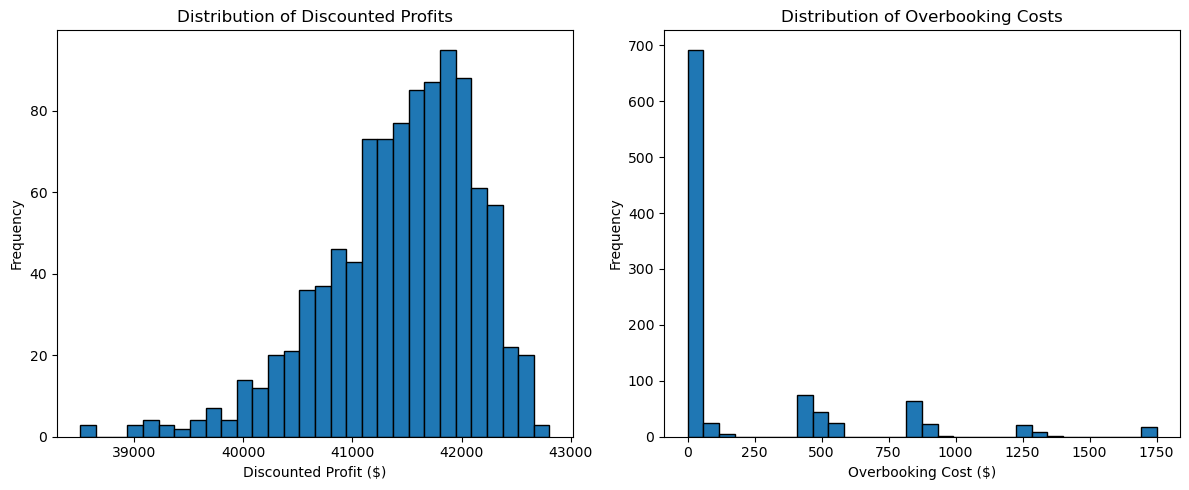

In [17]:
V_5, pol_c_5, pol_f_5, profit_5 = solve_airline_overbooking(overbook=5)
print("Optimal DP profit with overbooking = 5:", profit_5)
sim_basic = simulate_forward(pol_c_5, pol_f_5, overbook=5, N=1000, seed=42)

<br>

**2. For basic 2-option policy with 10 overbooked seats:**

Optimal DP profit with overbooking = 10: 42094.4307402182
Simulated average discounted profit: $41737.55
Profit volatility (std dev): $955.03
Average overbooking cost: $1400.05
Proportion of simulations with coach overbooked: 1.00
Average number of passengers kicked off: 3.20


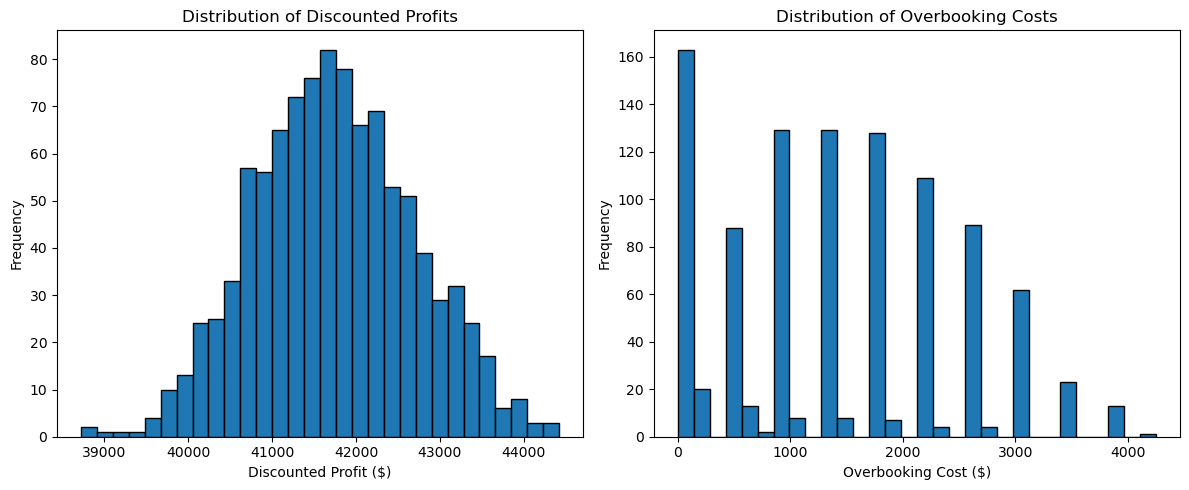

In [18]:
V_10, pol_c_10, pol_f_10, profit_10 = solve_airline_overbooking(overbook=10)
print("Optimal DP profit with overbooking = 10:", profit_10)
sim_basic = simulate_forward(pol_c_10, pol_f_10, overbook=10, N=1000, seed=42)

<br>

**3. For no sale policy and seasonality with no overbooking:** 

Simulated average discounted profit (no overbooking, no-sale Policy): $40138.17
Profit volatility (std dev): $551.58
Average overbooking cost (should be near 0): $0.00


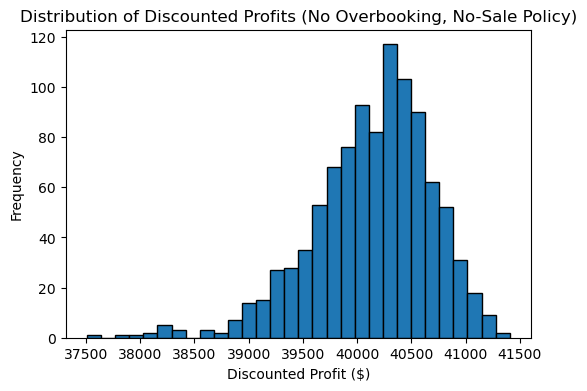

In [19]:
sim_results_no_over = simulate_forward_no_overbooking_nosale(pol_c_no_over, pol_f_no_over, N=1000, seed=42)

<br>

**4. For basic 2-option policy (with seasonality) with overbooking = 5:** 

Optimal DP profit with seasonality (overbooking = 5): 42090.93842342344
Simulated average discounted profit: $41196.39
Profit volatility (std dev): $735.62
Average overbooking cost: $205.88
Proportion of simulations with coach overbooked: 1.00
Average number of passengers kicked off: 0.45


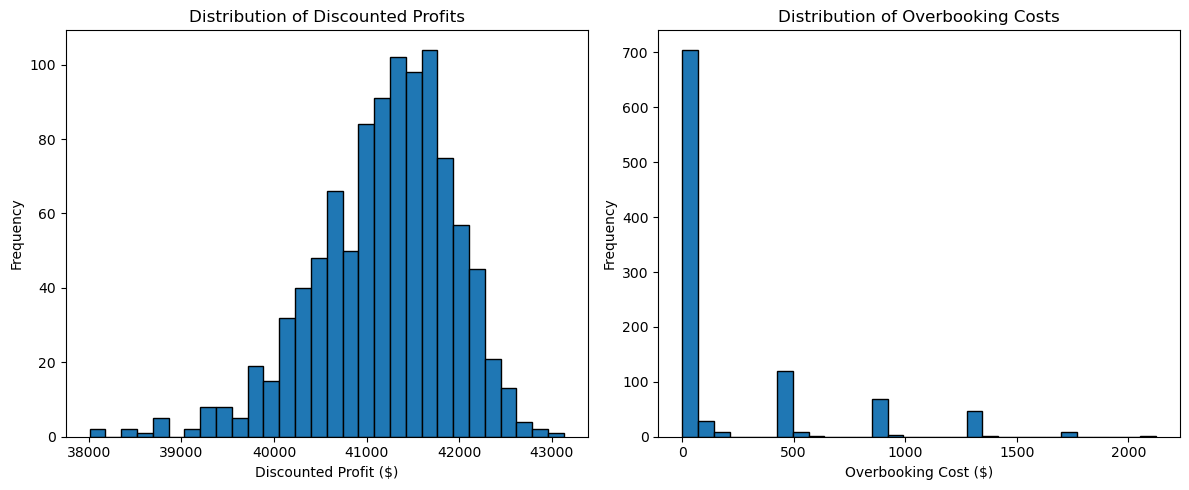

In [20]:
V_seas_5, pol_c_seas_5, pol_f_seas_5, profit_seas_5 = solve_airline_overbooking_with_Seasonality(overbook=5)
print("Optimal DP profit with seasonality (overbooking = 5):", profit_seas_5)
sim_results_seas_5 = simulate_forward(pol_c_seas_5, pol_f_seas_5, overbook=5, N=1000, seed=42)

<br>

**5. For basic 2-option policy (with seasonality) with overbooking = 10:** 

Optimal DP profit with seasonality (overbooking = 10): 42395.66523009648
Simulated average discounted profit: $41393.83
Profit volatility (std dev): $993.30
Average overbooking cost: $1624.62
Proportion of simulations with coach overbooked: 1.00
Average number of passengers kicked off: 3.72


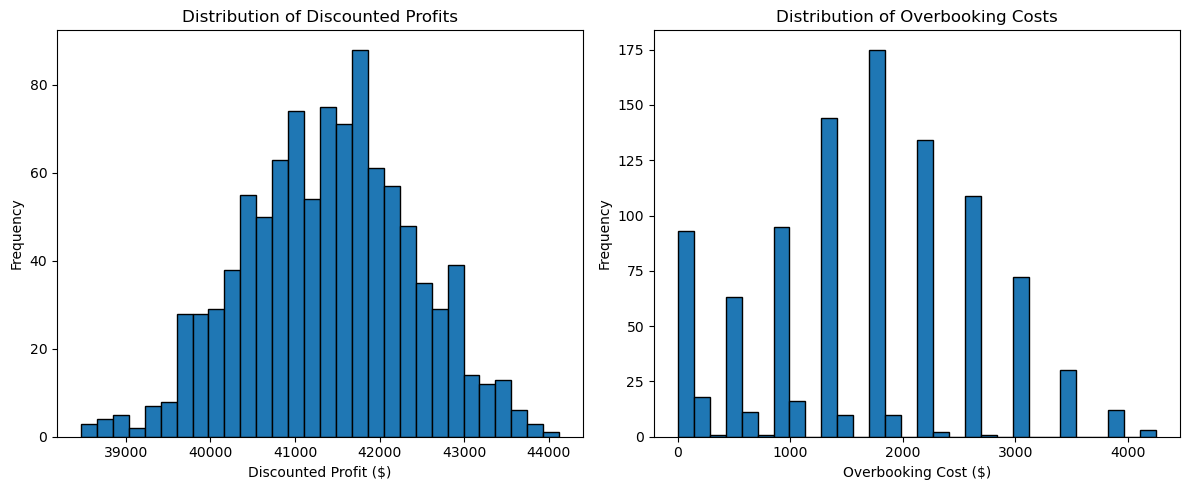

In [21]:
V_seas_10, pol_c_seas_10, pol_f_seas_10, profit_seas_10 = solve_airline_overbooking_with_Seasonality(overbook=10)
print("Optimal DP profit with seasonality (overbooking = 10):", profit_seas_10)
sim_results_seas_10 = simulate_forward(pol_c_seas_10, pol_f_seas_10, overbook=10, N=1000, seed=42)

**6. For the no-sale policy (with seasonality) and with overbooking = 5:**

Optimal DP profit with seasonality & no-sale option (overbooking = 5): 42171.88278731238
Simulated average discounted profit: $41278.32
Profit volatility (std dev): $694.96
Average overbooking cost: $240.72
Proportion of simulations with coach overbooked: 1.00
Average number of passengers kicked off: 0.54


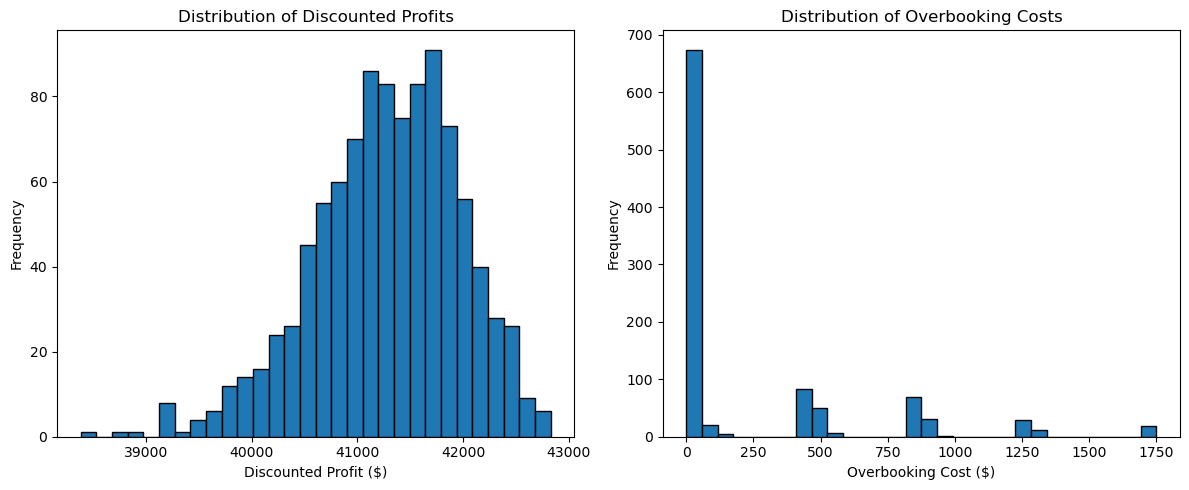

In [22]:
V_nosale, pol_c_nosale, pol_f_nosale, profit_nosale = solve_airline_overbooking_with_Seasonality_nosale(overbook=5)
print("Optimal DP profit with seasonality & no-sale option (overbooking = 5):", profit_nosale)
sim_nosale = simulate_forward(pol_c_nosale, pol_f_nosale, overbook=5, N=1000, seed=42)

<br>

**7. For the no-sale policy (with seasonality) and with overbooking = 10:**

Optimal DP profit with seasonality & no-sale option (overbooking = 10): 42436.21357316719
Simulated average discounted profit: $41403.10
Profit volatility (std dev): $927.76
Average overbooking cost: $1385.83
Proportion of simulations with coach overbooked: 1.00
Average number of passengers kicked off: 3.18


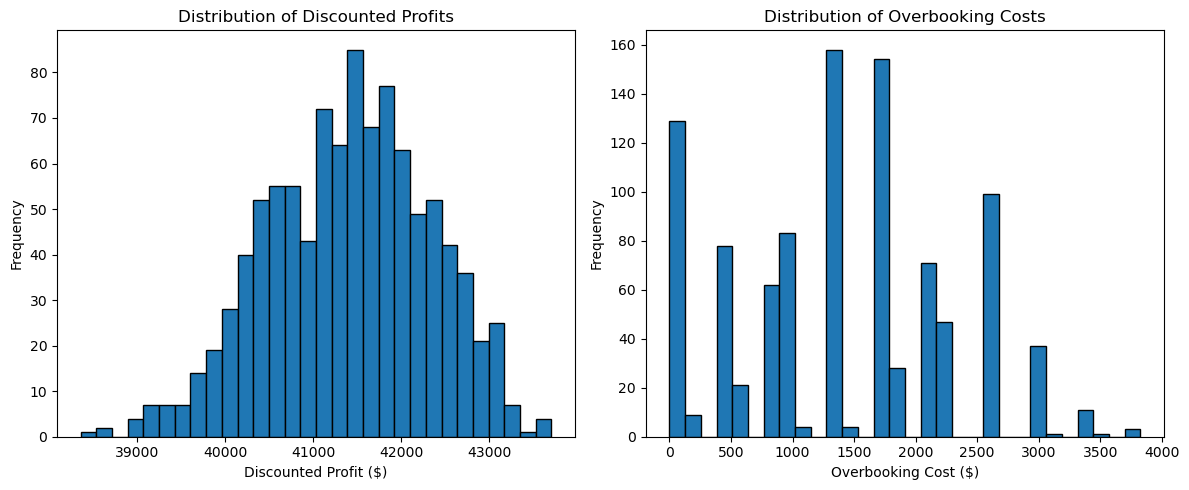

In [23]:
V_nosale, pol_c_nosale, pol_f_nosale, profit_nosale = solve_airline_overbooking_with_Seasonality_nosale(overbook=10)
print("Optimal DP profit with seasonality & no-sale option (overbooking = 10):", profit_nosale)
sim_nosale = simulate_forward(pol_c_nosale, pol_f_nosale, overbook=10, N=1000, seed=42)

<br>